# Predizione del diabete mediante algoritmi di apprendimento supervisionato

Definisco la classe con cui importo i dati dal dataset in formato .csv. [Link del dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)


Importo le librerie necessarie

In [1]:
from seaborn.matrix import heatmap
import matplotlib.pyplot as plt
import pandas as pd

Definisco due costanti: ovvero target predetto e nome del file csv

In [2]:
DIABETES_DATA_FILE = "diabetes.csv"
TARGET = "Outcome"

Definisco la classe diabetes_data

In [3]:
class diabetes_data:

    def __init__(self):
        self.data = pd.read_csv(DIABETES_DATA_FILE)
        del self.data['Pregnancies']
        self.features_list = list(self.data.columns)

    def get_data(self):
        return self.data

    def get_features(self):
        return self.features_list

    def get_heatmap(self):
        heatmap(self.data.corr(), annot=True)
        plt.title("Confusion matrix data")
        plt.show()

    def plot_outcomes(self):
        plt.style.use("ggplot")
        self.data["Outcome"].value_counts().plot.bar(
            title='Outcome', rot=0)
        plt.show()

    def plot_ages(self):
        plt.style.use("ggplot")
        list_ages = []
        for a in self.data["Age"]:
            for e in range(0,100,10):
                if a >= e and a <= (e+9):
                    label = "%d-%d"%(e,(e+9))
                    list_ages.append(label)
        pd.DataFrame(list_ages).value_counts().plot.bar(
            title='Ages', rot=0)
        plt.show()

    def plot_BMI(self):
        plt.style.use("ggplot")
        list_BMI = []

        for bmi in self.data["BMI"]:
            for b in range(0,70,10):
                if bmi >= b and b <=(bmi+9):
                    label = "%d-%d"%(b,(b+9))
                    list_BMI.append(label)
        pd.DataFrame(list_BMI).value_counts().plot.bar(
            title='BMI', rot=0)
        plt.show()

    def get_training_data(self):

        y = self.data[[TARGET]].values
        x = self.data.drop(TARGET, axis='columns').values

        return x, y


### Definisco le classi dei modelli di apprendimento supervisionato

Importo le librerie e le dipendenze necessarie

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import matplotlib.pyplot as plt
from typing import Final
from diabetes_data import diabetes_data
import graphviz as gpz

Definisco la classe base diabetes_model

In [5]:
class diabetes_model:

    def __init__(self, model, x, y, scores_dict: dict, test_size: float):

        default_test_size: Final = 0.5

        if self.__check_test_size(test_size) == False:
            test_size = default_test_size

        self.model = model
        self.x = x
        self.y = y
        self.scores = scores_dict
        self.test_size = test_size
        self.target = "Outcome"

    def get_x(self):
        return self.x

    def get_y(self):
        return self.y

    def get_metric(self, score_label: str):

        score_val = None

        if score_label in self.scores.keys():
            score_val = self.scores[score_label]

        return score_val

    def print_metrics(self):
        for s in self.scores.keys():
            print("%s : %.3f" % (str(s), self.scores[s]))

    def __check_test_size(self, test_size: float):

        valid = False

        if test_size > 0 and test_size < 1:
            valid = True

        return valid

Definisco l'algoritmo di regressione logistica per la classificazione dei casi di diabete

In [6]:
class diabetes_logistic_regression(diabetes_model):

    def __init__(self, data: diabetes_data, iterations: int, test_size: float):
        default_iterations: Final = 100

        if iterations < 1:
            iterations = default_iterations

        x, y = data.get_training_data()
        diabetes_model.__init__(self, LogisticRegression(
            max_iter=iterations), x, y, {}, test_size)

        self.test_size = test_size

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=self.test_size)
        self.y_predicted = None

    def predict(self):
        scaler = StandardScaler()
        self.x_train = scaler.fit_transform(self.x_train)
        self.x_test = scaler.fit_transform(self.x_test)

        self.model.fit(self.x_train, self.y_train.ravel())

        self.y_predicted = self.model.predict(self.x_test)

        # calcolo e memorizzo le metriche di valutazione sul modello
        self.scores["Accurancy"] = accuracy_score(
            self.y_test, self.y_predicted)
        self.scores["Precision"] = precision_score(
            self.y_test, self.y_predicted)
        self.scores["Recall"] = recall_score(self.y_test, self.y_predicted)
        self.scores["F1_precision"] = f1_score(self.y_test, self.y_predicted)

    def get_confusion_matrix(self):
        conf_matrix = confusion_matrix(self.y_test, self.y_predicted)
        disp_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp_matrix.plot()
        plt.grid(False)
        plt.title("Confusion matrix Logistic Regression")
        plt.show()

Definisco l'albero di decisone per la classificazione dei casi di diabete

In [7]:
class diabetes_decision_tree(diabetes_model):

    def __init__(self, data: diabetes_data, max_d: int, test_size: float):
        default_tree_depth: Final = 10

        if max_d < 1:
            max_d = default_tree_depth

        x, y = data.get_training_data()

        diabetes_model.__init__(self, tree.DecisionTreeClassifier(
            max_depth=max_d), x, y, {}, test_size)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=self.test_size)
        self.y_predicted = None

    def predict(self):
        scaler = StandardScaler()
        self.x_train = scaler.fit_transform(self.x_train)
        self.x_test = scaler.fit_transform(self.x_test)

        self.model.fit(self.x_train, self.y_train.ravel())
        self.y_predicted = self.model.predict(self.x_test)

        # calcolo e memorizzo le metriche di valutazione sul modello
        self.scores["Accurancy"] = accuracy_score(
            self.y_test, self.y_predicted)
        self.scores["Precision"] = precision_score(
            self.y_test, self.y_predicted)
        self.scores["Recall"] = recall_score(self.y_test, self.y_predicted)
        self.scores["F1_precision"] = f1_score(self.y_test, self.y_predicted)

    def get_confusion_matrix(self):
        conf_matrix = confusion_matrix(self.y_test, self.y_predicted)
        disp_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp_matrix.plot()
        plt.grid(False)
        plt.title("Confusion matrix Decision Tree")
        plt.show()

Definisco l'algoritmo K-NN per la classificazione dei casi di diabete

In [8]:
class diabetes_knn(diabetes_model):

    def __init__(self, data: diabetes_data, test_size: float, neighbors: int):
        
        x, y = data.get_training_data()
        self.neighbors = neighbors
        diabetes_model.__init__(self, KNeighborsClassifier(
            n_neighbors=self.neighbors), x, y, {}, test_size)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=self.test_size)

        self.y_predicted = None
    
    def predict(self):

        scaler = StandardScaler()
        self.x_train = scaler.fit_transform(self.x_train)
        self.x_test = scaler.fit_transform(self.x_test)

        self.model.fit(self.x_train, self.y_train.ravel())
        self.y_predicted = self.model.predict(self.x_test)

        # calcolo e memorizzo le metriche di valutazione sul modello
        self.scores["Accurancy"] = accuracy_score(
            self.y_test, self.y_predicted)
        self.scores["Precision"] = precision_score(
            self.y_test, self.y_predicted)
        self.scores["Recall"] = recall_score(self.y_test, self.y_predicted)
        self.scores["F1_precision"] = f1_score(self.y_test, self.y_predicted)

    def get_confusion_matrix(self):
        conf_matrix = confusion_matrix(self.y_test, self.y_predicted)
        disp_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp_matrix.plot()
        plt.grid(False)
        plt.title("Confusion matrix K-Nearest-Neighbor")
        plt.show()

### Definisco delle funzioni per il plotting delle metrice di Accuratezza, Precision, Recall ed F1-precision al variare dei parametri nei modelli

Importo le librerie necessarie

In [9]:
from models import *
from numpy import linspace
import matplotlib.pyplot as plt
from diabetes_data import diabetes_data

Definisco le funzioni

In [31]:
def get_linspace(start: int,end: int,step: int):

    linspace_vect = []

    for i in range(start,end,step):
        linspace_vect.append(i)
    
    return linspace_vect

def metrics_graph_lr(data: diabetes_data, test_size: float):

    iterations_vect = linspace(0, 2000, 100)
    precision_vect = []
    recall_vect = []
    f1_score_vect = []
    accurancy_vect = []

    a,graph_lr = plt.subplots(2,2)

    i = 0
    while i < len(iterations_vect):

        model_i = diabetes_logistic_regression(data,iterations_vect[i],test_size)

        model_i.predict()
        accurancy_vect.append(model_i.get_metric("Accurancy"))
        precision_vect.append(model_i.get_metric("Precision"))
        recall_vect.append(model_i.get_metric("Recall"))
        f1_score_vect.append(model_i.get_metric("F1_precision"))

        i = i + 1

    graph_lr[0,0].plot(iterations_vect, accurancy_vect)
    graph_lr[0,0].set_title("Accurancy - Logistic Regression")

    graph_lr[0,1].plot(iterations_vect,precision_vect)
    graph_lr[0,1].set_title("Precision - Logistic Regression")

    graph_lr[1,0].plot(iterations_vect, recall_vect)
    graph_lr[1,0].set_title("Recall - Logistic Regression")

    graph_lr[1,1].plot(iterations_vect, f1_score_vect)
    graph_lr[1,1].set_title("F1_Precision - Logistic Regression")
    plt.show()

def metrics_graph_dt(data: diabetes_data, test_size: float):

    iterations_vect = linspace(0, 200, 5)
    precision_vect = []
    recall_vect = []
    f1_score_vect = []
    accurancy_vect = []

    a,graph_lr = plt.subplots(2,2)

    i = 0
    while i < len(iterations_vect):

        model_i = diabetes_decision_tree(data, iterations_vect[i],test_size)

        model_i.predict()
        accurancy_vect.append(model_i.get_metric("Accurancy"))
        precision_vect.append(model_i.get_metric("Precision"))
        recall_vect.append(model_i.get_metric("Recall"))
        f1_score_vect.append(model_i.get_metric("F1_precision"))

        i = i + 1

    graph_lr[0,0].plot(iterations_vect, accurancy_vect)
    graph_lr[0,0].set_title("Accurancy - Decision Tree")

    graph_lr[0,1].plot(iterations_vect,precision_vect)
    graph_lr[0,1].set_title("Precision - Decision Tree")

    graph_lr[1,0].plot(iterations_vect, recall_vect)
    graph_lr[1,0].set_title("Recall - Decision Tree")

    graph_lr[1,1].plot(iterations_vect, f1_score_vect)
    graph_lr[1,1].set_title("F1_Precision - Decision Tree")
    plt.show()

def metrics_graph_knn(data: diabetes_data, test_size: float):

    iterations_vect = get_linspace(1, 50, 1)
    precision_vect = []
    recall_vect = []
    f1_score_vect = []
    accurancy_vect = []

    a,graph_lr = plt.subplots(2,2)

    i = 0
    while i < len(iterations_vect):

        model_i = diabetes_knn(data,test_size,iterations_vect[i])

        model_i.predict()
        accurancy_vect.append(model_i.get_metric("Accurancy"))
        precision_vect.append(model_i.get_metric("Precision"))
        recall_vect.append(model_i.get_metric("Recall"))
        f1_score_vect.append(model_i.get_metric("F1_precision"))

        i = i + 1

    graph_lr[0,0].plot(iterations_vect, accurancy_vect)
    graph_lr[0,0].set_title("Accurancy - KNN")

    graph_lr[0,1].plot(iterations_vect,precision_vect)
    graph_lr[0,1].set_title("Precision - KNN")

    graph_lr[1,0].plot(iterations_vect, recall_vect)
    graph_lr[1,0].set_title("Recall - KNN")

    graph_lr[1,1].plot(iterations_vect, f1_score_vect)
    graph_lr[1,1].set_title("F1_Precision - KNN")
    plt.show()
    
def comparison_metrics_models(data: diabetes_data, test_size: float):

    model_1 = diabetes_logistic_regression(data, 100, test_size)
    model_1.predict()

    model_2 = diabetes_decision_tree(data, 50, test_size)
    model_2.predict()

    model_3 = diabetes_knn(data, test_size, 21)
    model_3.predict()

    a, graph_lr = plt.subplots(2, 2)
    a.tight_layout(pad=4.0)

    precision_data_dict = {"Logistic_Regression": model_1.get_metric("Precision"), "Decision_Tree": model_2.get_metric(
        "Precision"), "K-Nearest-Neighbor": model_3.get_metric("Precision")}

    recall_data_dict = {"Logistic_Regression": model_1.get_metric("Recall"), "Decision_Tree": model_2.get_metric(
        "Recall"), "K-Nearest-Neighbor": model_3.get_metric("Recall")}

    f1_data_dict = {"Logistic_Regression": model_1.get_metric("F1_precision"), "Decision_Tree": model_2.get_metric(
        "F1_precision"), "K-Nearest-Neighbor": model_3.get_metric("F1_precision")}

    accurancy_data_dict = {"Logistic_Regression": model_1.get_metric("Accurancy"), "Decision_Tree": model_2.get_metric(
        "Accurancy"), "K-Nearest-Neighbor": model_3.get_metric("Accurancy")}

    models_names = list(precision_data_dict.keys())

    models_precision_data = list(precision_data_dict.values())
    models_recall_data = list(recall_data_dict.values())
    models_f1_data = list(f1_data_dict.values())
    models_accurancy_data = list(accurancy_data_dict.values())

    graph_lr[0, 0].bar(models_names, models_precision_data, color="red", width = 1.2)
    graph_lr[0, 0].set_title("Precision")

    graph_lr[0, 1].bar(models_names, models_recall_data, color="green")
    graph_lr[0, 1].set_title("Recall")

    graph_lr[1, 0].bar(models_names, models_f1_data, color="purple")
    graph_lr[1, 0].set_title("F1-precision")

    graph_lr[1, 1].bar(models_names, models_accurancy_data, color="blue")
    graph_lr[1, 1].set_title("Accurancy")

    plt.show()


## Visualizzo il dataset e utilizzo i modelli  definiti

In [32]:
from diabetes_data import diabetes_data
from model_comparison import *
from models import *

Creo l'oggetto diabetes_data e visualizzo i dati

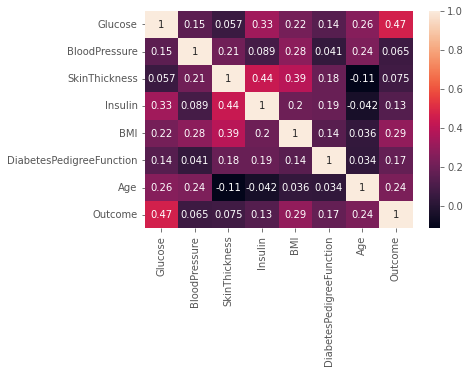

In [33]:
data = diabetes_data()
data.get_heatmap()

Visualizzo il numero di casi di diabete presenti nel dataset

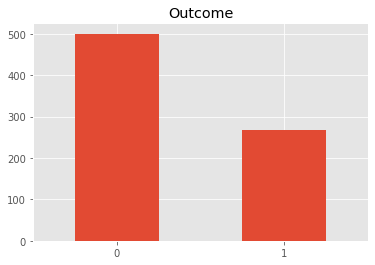

In [34]:
data.plot_outcomes()

'0' indica i soggetti sani mentre '1' indica i soggetti malati di diabete

Plotting delle età

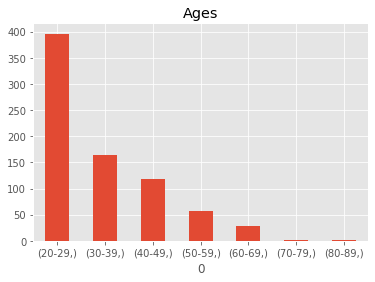

In [35]:
data.plot_ages()

Plotting degli indici di massa corporea

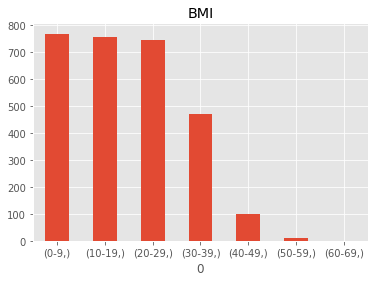

In [36]:
data.plot_BMI()

### Richiamo i modelli di apprendimento supervisionato

Creo il modello di regressione logistica

In [37]:
model_1 = diabetes_logistic_regression(data,100,0.5)
model_1.predict()

Stampo le metriche 

In [38]:
model_1.print_metrics()

Accurancy : 0.773
Precision : 0.716
Recall : 0.582
F1_precision : 0.642


Stampo la matrice di confusione

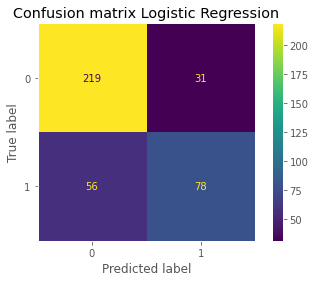

In [39]:
model_1.get_confusion_matrix()

Definisco l'albero di decisione

In [40]:
model_2 = diabetes_decision_tree(data,50,0.5)
model_2.predict()

Stampo le metriche 

In [41]:
model_2.print_metrics()

Accurancy : 0.685
Precision : 0.581
Recall : 0.486
F1_precision : 0.529


Stampo la matrice di confusione

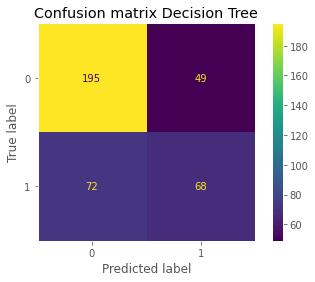

In [42]:
model_2.get_confusion_matrix()

Definisco il modello K-Nearest-Neighbor

In [43]:
model_3 = diabetes_knn(data,0.5,20)
model_3.predict()

Stampo le metriche

In [44]:
model_3.print_metrics()

Accurancy : 0.745
Precision : 0.685
Recall : 0.466
F1_precision : 0.555


Stampo la matrice di confusione 

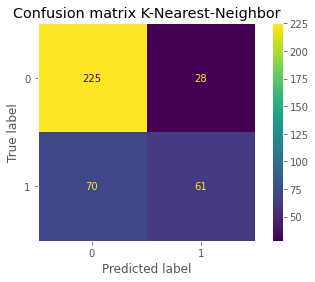

In [45]:
model_3.get_confusion_matrix()

In [46]:
# Commento su i modelli 

Eseguo il plot delle metriche di Accurancy, Precision, Recall ed F1-precision per ognuno dei tre modelli creati al variare dei parametri.

In [47]:
default_test_size = 0.5

Plotting per la regressione logistica

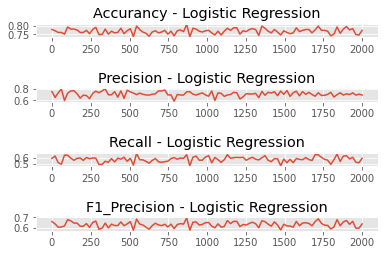

In [48]:
metrics_graph_lr(data,default_test_size)

Plotting per l'albero di decisione

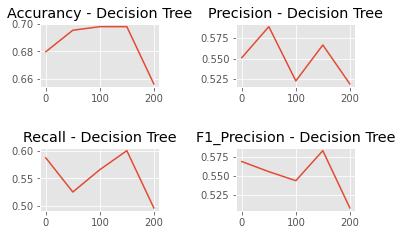

In [49]:
metrics_graph_dt(data,default_test_size)

Plotting per il K-NN

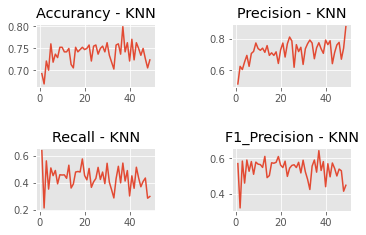

In [50]:
metrics_graph_knn(data,default_test_size)